# Josh Balingit Code

# Image Conversion

In [1]:
import numpy as np
import requests
from PIL import Image
from io import BytesIO

image1_link = "https://images.squarespace-cdn.com/content/v1/5a98653d96e76f7f7dc569c7/1652203191222-16N8MP7K7EACDQ1EVJ7E/shot_orange_marilyn_1964-19604.png?format=960w"
image2_link = "https://images.squarespace-cdn.com/content/v1/5a98653d96e76f7f7dc569c7/1652203192094-MIQYNYEIJYJBY957F7T7/shot_red_marilyn_1964-19604.png?format=960w"
image3_link = "https://images.squarespace-cdn.com/content/v1/5a98653d96e76f7f7dc569c7/1652213792503-2Q9A294S9UOFEBQZQQNP/shot_turq_marilyn_1964-19604.png?format=960w"
image4_link = "https://images.squarespace-cdn.com/content/v1/5a98653d96e76f7f7dc569c7/1652203207667-AHQD95AZ4Z1MCZ5B4C0N/shot_blue_marilyn_1964-19604.jpg?format=960w"
image5_link = "https://images.squarespace-cdn.com/content/v1/5a98653d96e76f7f7dc569c7/1652203189304-UFR2YYN9605G0IW13YHJ/shot_eggblue_marilyn_1964-19604.png?format=960w"

def image_matrix(url_text):
    url = url_text
    response = requests.get(url)
    image = Image.open(BytesIO(response.content))
    image_matrix = np.array(image)
    if np.shape(image_matrix) == (960, 960, 3):
        return image_matrix
    else:
        return image_matrix[:, :, :3]

image1_matrix = image_matrix(image1_link)
image2_matrix = image_matrix(image2_link)
image3_matrix = image_matrix(image3_link)
image4_matrix = image_matrix(image4_link)
image5_matrix = image_matrix(image5_link)

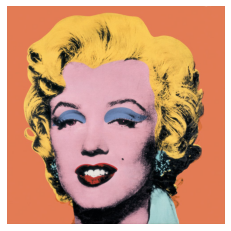

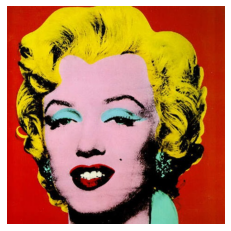

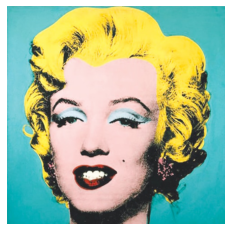

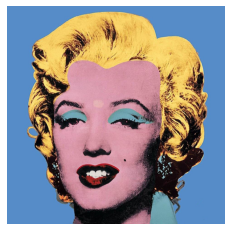

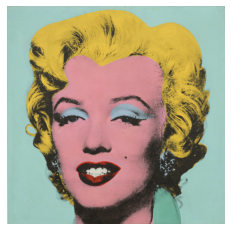

In [2]:
import matplotlib.pyplot as plt

plt.imshow(image1_matrix) # Large Amount of Masquera
plt.axis('off')  
plt.show()
plt.imshow(image2_matrix) # Alive ("Fury"), Energetic ("Anger"), Popping <-> Saturated Hair AND Darker Shadow ("Menacing")
plt.axis('off')  
plt.show()
plt.imshow(image3_matrix) # Makeup "Blend" with Face and Collar "Blend" with Background and Hairline "Blend" with Face AND Brighter Atmosphere AND Slightly Tilted Up
plt.axis('off')  
plt.show()
plt.imshow(image4_matrix) # Circlular Mark on Forehead
plt.axis('off')  
plt.show()
plt.imshow(image5_matrix) # Consistency in Color <-> Less Realistic, Dull, Lifeless
plt.axis('off')  
plt.show()

# Extraction

In [3]:
import pandas as pd
import seaborn as sns
import fastcluster
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist
from collections import OrderedDict

In [4]:
def reshape_compress_unique(image_mat,kind="rcu"):
    image_mat_reshape = image_mat.reshape(-1, 3)
    if kind == "r":
        return image_mat_reshape
    image_mat_reshape_compress = (image_mat_reshape // 10) * 10 + 4
    if kind == "rc":
        return image_mat_reshape_compress
    image_mat_reshape_compress_unique = np.unique(image_mat_reshape_compress,axis=0)
    if kind == "rcu":
        return image_mat_reshape_compress_unique
def color_cluster(image_mat,x_size=20,y_size=10,threshold=0,y_increment=10,no_labels=True):
    ### Compress and extract unique "rounded" color
    image_mat_reshape_compress_unique = reshape_compress_unique(image_mat)
    ### Extract total number of unique "rounded" color
    N = image_mat_reshape_compress_unique.shape[0] 
    ### Perform hierarchical clustering using fastcluster package
    Z = fastcluster.linkage(image_mat_reshape_compress_unique, method='average') 
    ### Construct dendogram from fastcluster package documentation
    rgb_values = [tuple(i) for i in image_mat_reshape_compress_unique]
    hex_colors = ['#%02x%02x%02x' % rgb for rgb in rgb_values]
    plt.figure(figsize=(x_size, y_size))
    dg = sch.dendrogram(Z, 
                        no_labels = no_labels, ### Improve Computation Time
                        color_threshold=threshold, 
                        above_threshold_color='black')
    b = .1 * Z[-1, 2]
    bar_width = 10
    offset = bar_width/2
    plt.bar(np.arange(N) * 10 + offset, 
            np.ones(N) * b, 
            bottom = -b, 
            width = bar_width,
            color = [hex_colors[k] for k in dg['leaves']], 
            edgecolor = 'none')
    plt.gca().set_ylim((-b, None))
    distances = dg['dcoord']
    min_distance = np.min(distances)
    max_distance = np.max(distances)
    
    plt.xticks(fontsize=12)
    
    plt.yticks(np.arange(min_distance, max_distance, y_increment),fontsize=15)
    plt.ylabel('Distance',fontsize=15)
    plt.show()
    ### Return dendogram and linkage matrix Z
    return [dg,Z]
def desired_color_image(full_image_mat,image_mat,dg,Z,threshold,desired_cluster_order,print_image=True,contrast_color=[255,255,255],return_cl_pi_df=False):   
    ### Group indices by cluster
    clusters = sch.fcluster(Z, threshold, criterion='distance')
    cluster_indices = {}
    for i, cluster_label in enumerate(clusters):
        if cluster_label not in cluster_indices:
            cluster_indices[cluster_label] = []
        cluster_indices[cluster_label].append(i)
    ### Convert to data frame
    cl_pi_df = pd.DataFrame(cluster_indices.items(),
                            columns = ["cluster_label","pixel_index"])
    labels_left_to_right = list(OrderedDict.fromkeys(clusters[dg['leaves']]))
    cl_pi_df = cl_pi_df.set_index('cluster_label').reindex(labels_left_to_right).reset_index(drop=True).rename_axis('cluster_order',axis='index')
    ### Extract desired color
    image_mat_reshape_compress_unique = reshape_compress_unique(image_mat)
    desired_index_rcu = [i for sublist in list(cl_pi_df.loc[desired_cluster_order,"pixel_index"]) for i in sublist]
    desired_color_rcu = image_mat_reshape_compress_unique[desired_index_rcu].tolist()
    
    new_image_mat = full_image_mat.copy()
    OG_dim = new_image_mat.shape
    new_image_mat_reshape_compress = reshape_compress_unique(new_image_mat,kind="rc")
    desired_index = [i.tolist() in desired_color_rcu for i in new_image_mat_reshape_compress]
    new_image_mat_reshape = reshape_compress_unique(new_image_mat,kind="r")
    desired_color = pd.DataFrame(new_image_mat_reshape[desired_index],columns = ["R","G","B"])
    ### Print new image with contrast color
    if print_image == True:
        contrast_index = [not i for i in desired_index]
        new_image_mat_reshape[contrast_index] = contrast_color
        new_image_mat = new_image_mat_reshape.reshape(OG_dim)
        plt.imshow(new_image_mat)
        plt.axis('off')  
        plt.show()
    if return_cl_pi_df == False:
        return desired_color
    else:
        return [desired_color,cl_pi_df]

# Extract Background

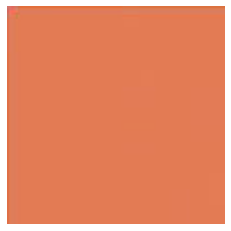

In [5]:
sample_background_image1_mat = image1_matrix[0:100,0:100,:]
plt.imshow(sample_background_image1_mat)
plt.axis('off')  
plt.show()

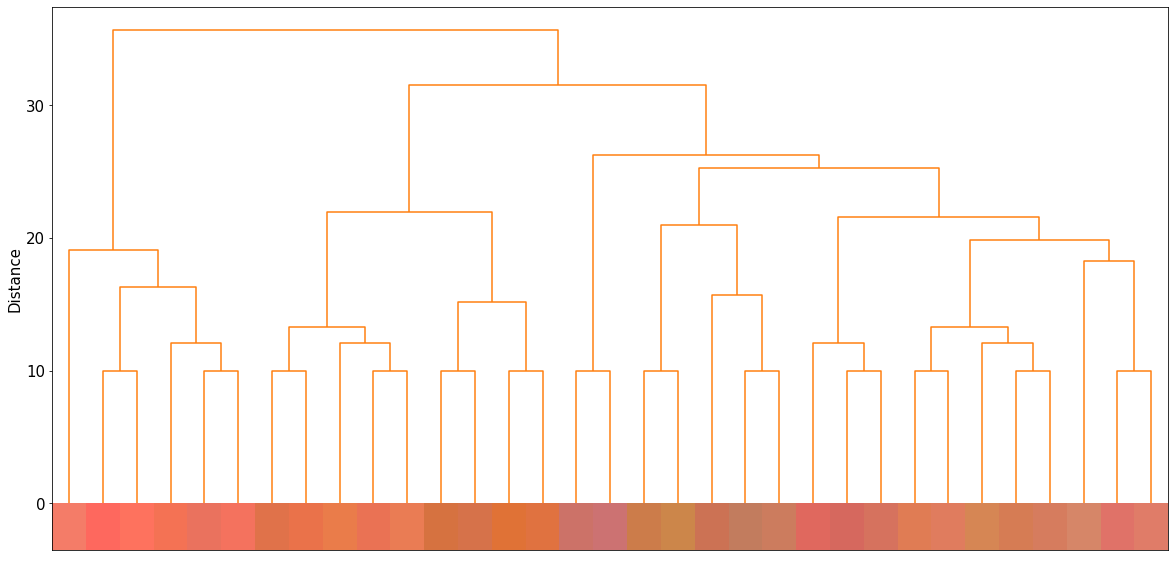

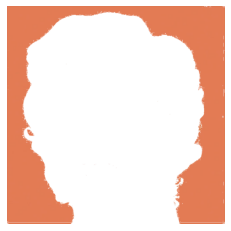

In [6]:
threshold = 50
dg,Z = color_cluster(sample_background_image1_mat,threshold=threshold)
desired_color_background_image1_df = desired_color_image(image1_matrix,
                                                         sample_background_image1_mat,
                                                         dg,
                                                         Z,
                                                         threshold,
                                                         desired_cluster_order=[0])

# Extract Hair

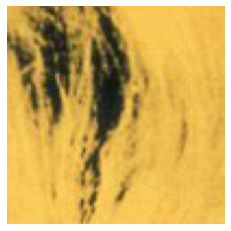

In [7]:
sample_hair_image1_mat = image1_matrix[100:200,400:500,:]
plt.imshow(sample_hair_image1_mat)
plt.axis('off')  
plt.show()

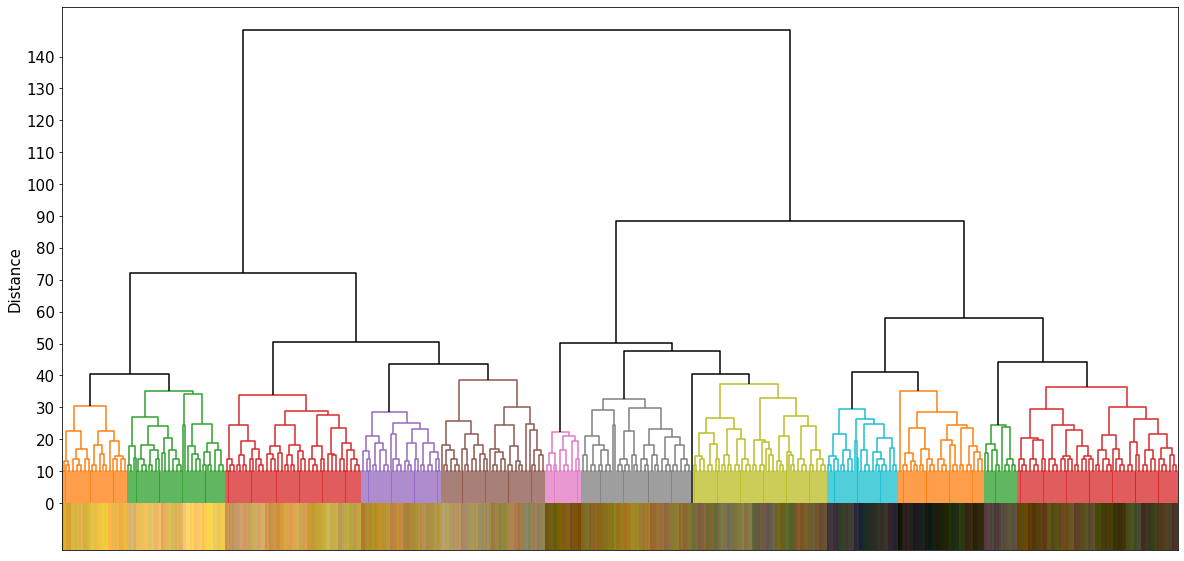

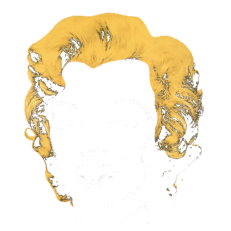

In [8]:
threshold = 40
dg,Z = color_cluster(sample_hair_image1_mat,threshold=threshold)
desired_color_hair_image1_df = desired_color_image(image1_matrix,
                                                   sample_hair_image1_mat,
                                                   dg,
                                                   Z,   
                                                   threshold,
                                                   desired_cluster_order=[0,1,2,3,4,5,6,7,8,11,12])

# Extract All Hair

In [9]:
def extract_print_image(mat,x_range='full',y_range='full',print_image=True,axis=False):
    if x_range == 'full' and y_range == 'full':
        new_mat = mat
    else:  
        new_mat = mat[x_range[0]:x_range[1],y_range[0]:y_range[1],:]

    if print_image == True: 
        plt.imshow(new_mat)
        if axis == False:
            plt.axis('off')  
        else:
            plt.axis()
        plt.show() 
    return new_mat

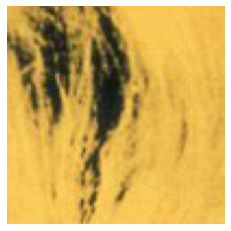

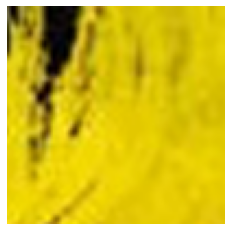

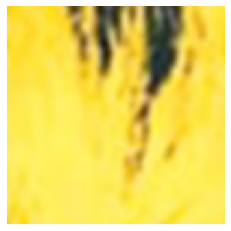

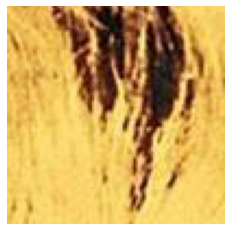

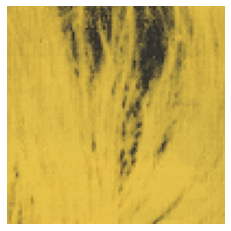

In [10]:
sample_hair_image1_mat = extract_print_image(image1_matrix,[100,200],[400,500])
sample_hair_image2_mat = extract_print_image(image2_matrix,[100,200],[400,500])
sample_hair_image3_mat = extract_print_image(image3_matrix,[100,200],[400,500])
sample_hair_image4_mat = extract_print_image(image4_matrix,[100,200],[400,500])
sample_hair_image5_mat = extract_print_image(image5_matrix,[100,200],[400,500])

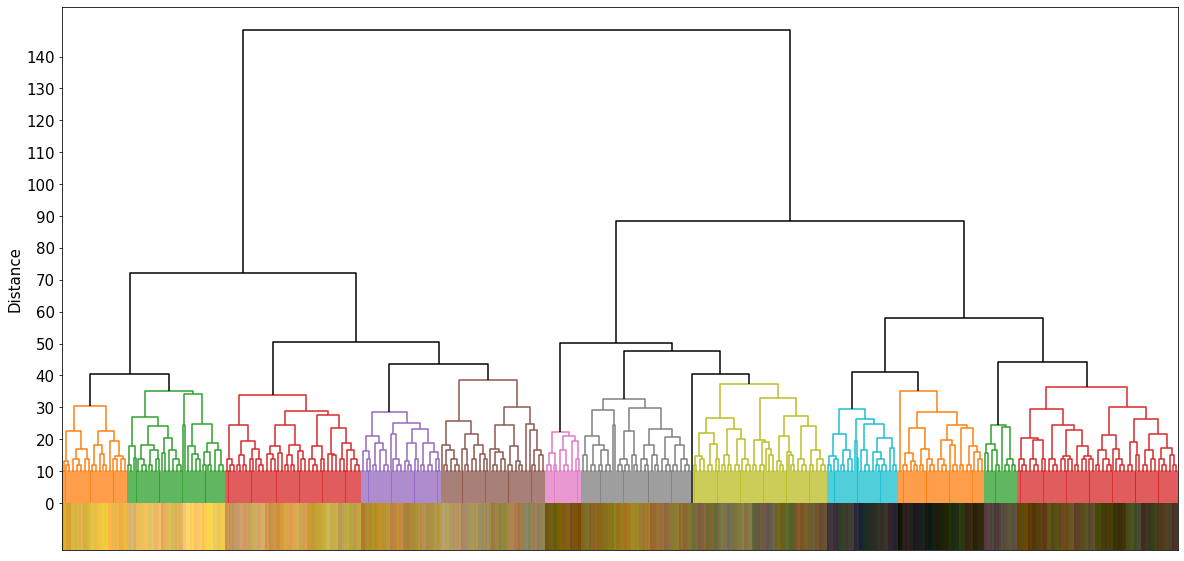

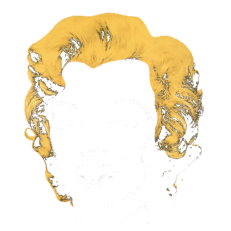

In [11]:
# Image 1
threshold = 40
dg,Z = color_cluster(sample_hair_image1_mat,threshold=threshold)
desired_color_hair_image1_df = desired_color_image(image1_matrix,
                                                   sample_hair_image1_mat,
                                                   dg,
                                                   Z,
                                                   threshold,
                                                   desired_cluster_order=[0,1,2,3,4,5,6,7,8,11,12])

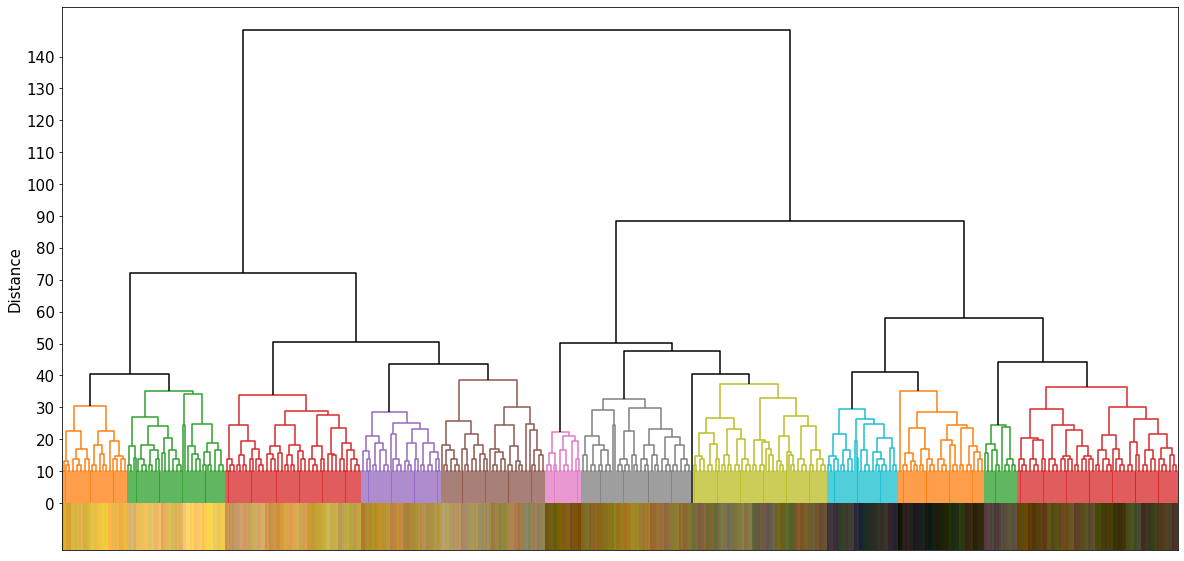

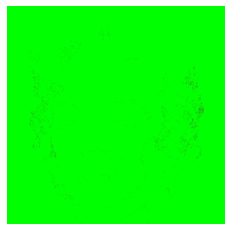

In [12]:
# Image 1
threshold = 40
dg,Z = color_cluster(sample_hair_image1_mat,threshold=threshold)
trial = desired_color_image(image1_matrix,
                            sample_hair_image1_mat,
                            dg,
                            Z,
                            threshold,
                            desired_cluster_order=[11],
                            contrast_color=[0,255,0])

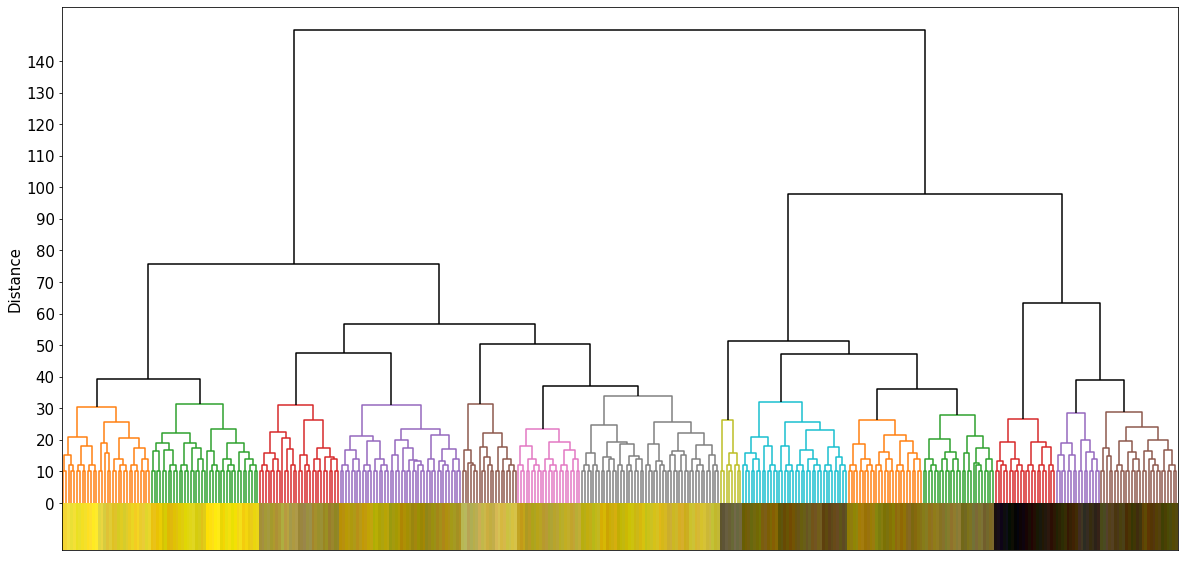

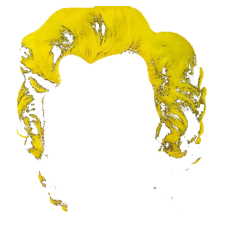

In [13]:
# Image 2
threshold = 35
dg,Z = color_cluster(sample_hair_image2_mat,threshold=threshold)
desired_color_hair_image2_df = desired_color_image(image2_matrix,
                                                   sample_hair_image2_mat,
                                                   dg,
                                                   Z,
                                                   threshold,
                                                   desired_cluster_order=[0,1,2,3,4,5,6,8,9,10,13])

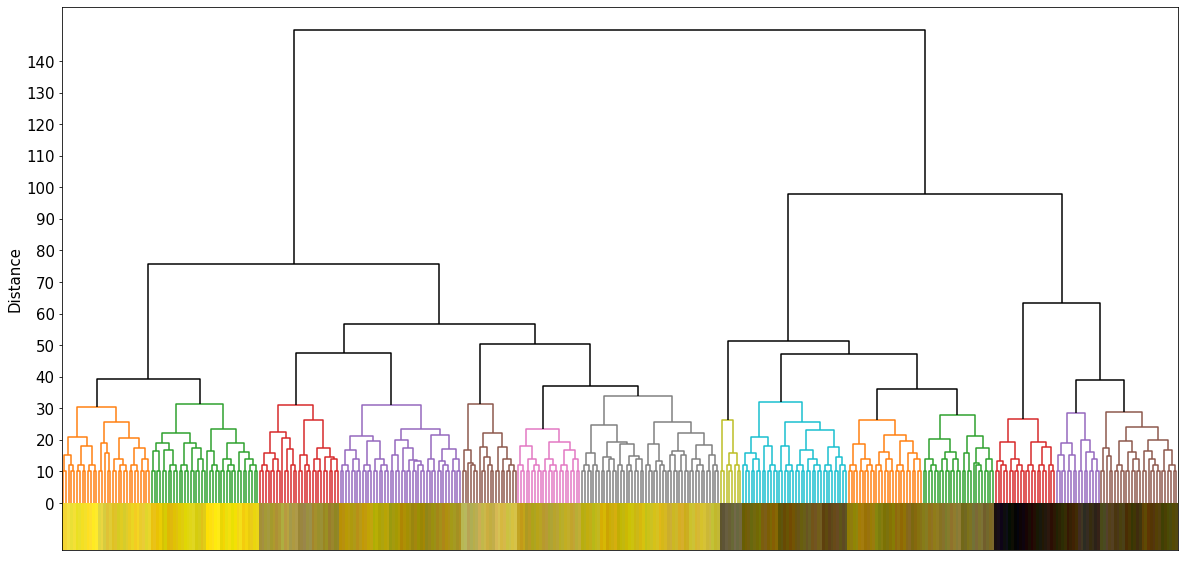

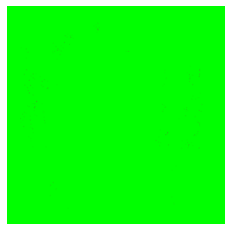

In [14]:
# Image 2
threshold = 35
dg,Z = color_cluster(sample_hair_image2_mat,threshold=threshold)
trial = desired_color_image(image2_matrix,
                            sample_hair_image2_mat,
                            dg,
                            Z,
                            threshold,
                            desired_cluster_order=[7],
                            contrast_color=[0,255,0])

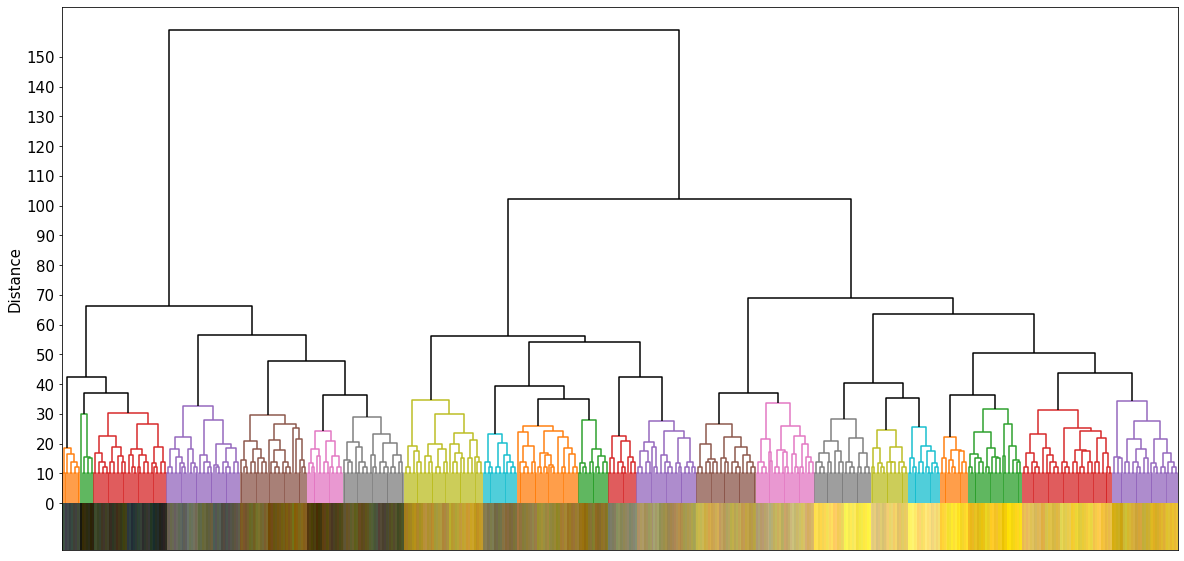

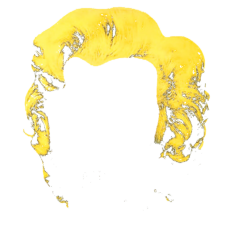

In [15]:
# Image 3
threshold = 35
dg,Z = color_cluster(sample_hair_image3_mat,threshold=threshold)
desired_color_hair_image3_df = desired_color_image(image3_matrix,
                                                   sample_hair_image3_mat,
                                                   dg,
                                                   Z,
                                                   threshold,
                                                   desired_cluster_order=[4,5,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21])

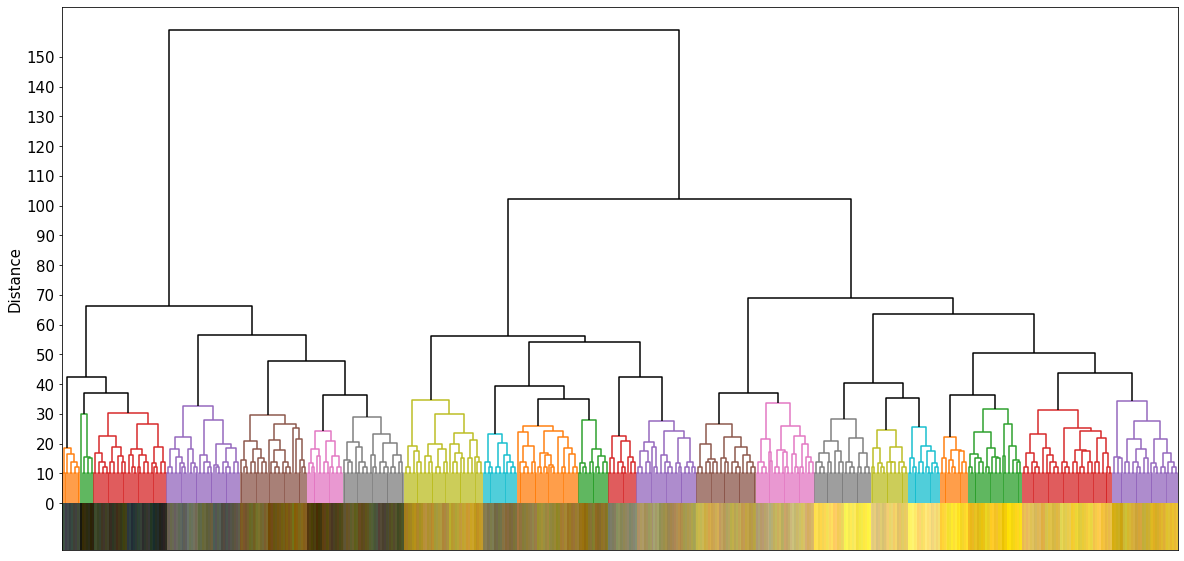

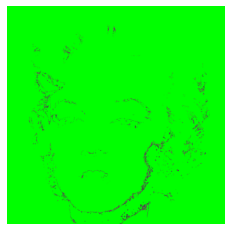

In [16]:
# Image 3
threshold = 35
dg,Z = color_cluster(sample_hair_image3_mat,threshold=threshold)
trial = desired_color_image(image3_matrix,
                            sample_hair_image3_mat,
                            dg,
                            Z,
                            threshold,
                            desired_cluster_order=[0,3],
                            contrast_color=[0,255,0])

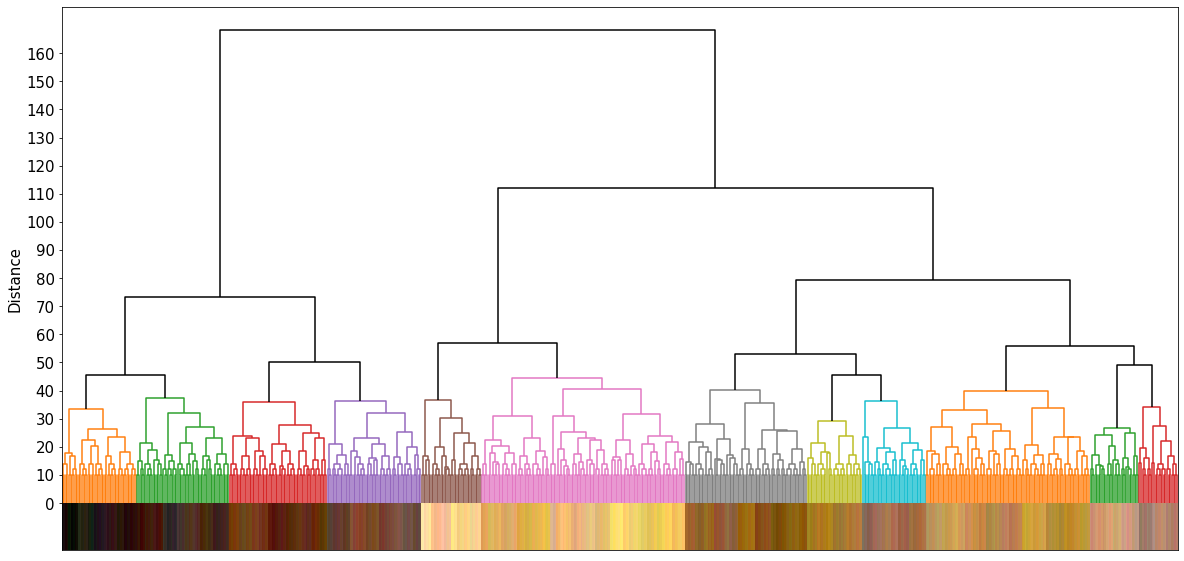

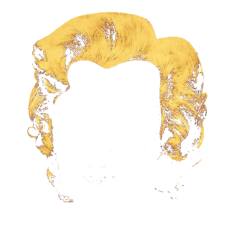

In [17]:
# Image 4
threshold = 45
dg,Z = color_cluster(sample_hair_image4_mat,threshold=threshold)
desired_color_hair_image4_df = desired_color_image(image4_matrix,
                                                   sample_hair_image4_mat,
                                                   dg,
                                                   Z,
                                                   threshold,
                                                   desired_cluster_order=[3,4,5,6,7,8,9,10,11]) # 2 includes hair and lips

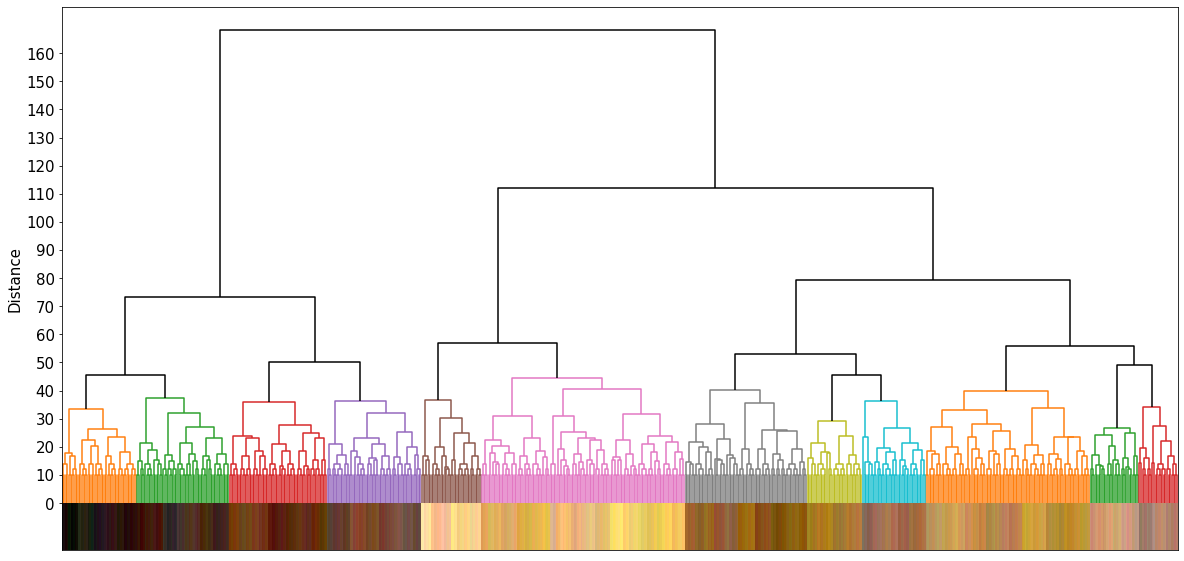

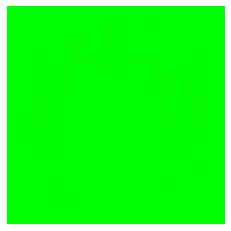

In [18]:
# Image 4
threshold = 45
dg,Z = color_cluster(sample_hair_image4_mat,threshold=threshold)
trial = desired_color_image(image4_matrix,
                            sample_hair_image4_mat,
                            dg,
                            Z,
                            threshold,
                            desired_cluster_order=[10],
                            contrast_color=[0,255,0])

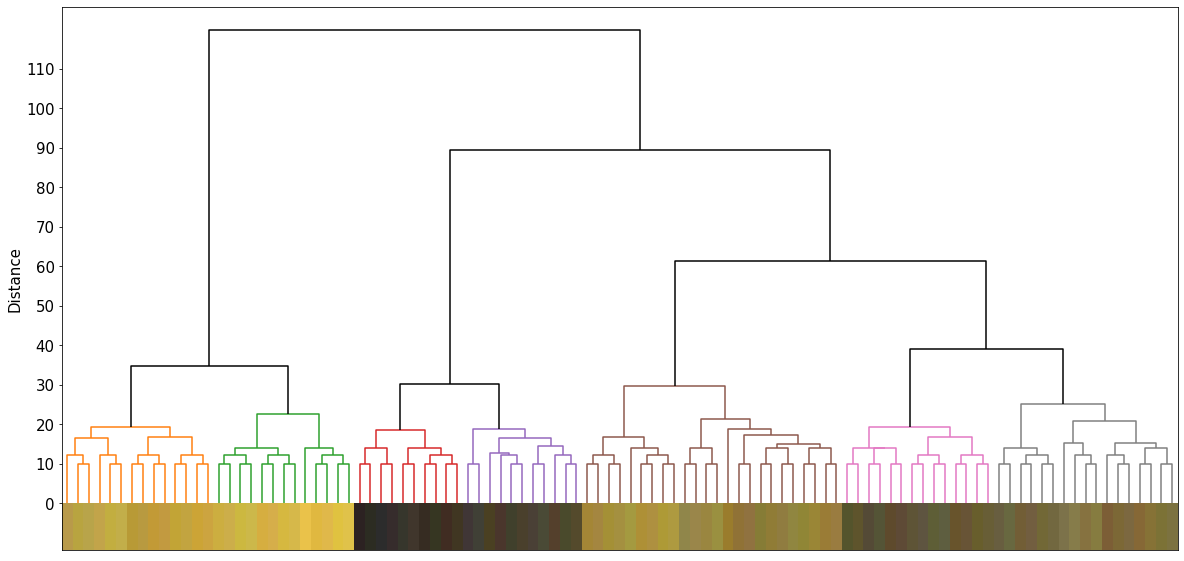

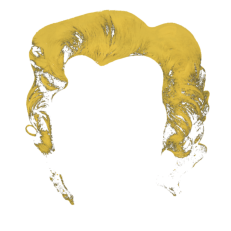

In [19]:
# Image 5
threshold = 30
dg,Z = color_cluster(sample_hair_image5_mat,threshold=threshold)
desired_color_hair_image5_df = desired_color_image(image5_matrix,
                                                   sample_hair_image5_mat,
                                                   dg,
                                                   Z,
                                                   threshold,
                                                   desired_cluster_order=[0,1,4,5,6])

# Analyze All Hair

In [20]:
import plotnine as p9

In [21]:
all_hair_df = pd.concat([desired_color_hair_image1_df,
                         desired_color_hair_image2_df,
                         desired_color_hair_image3_df,
                         desired_color_hair_image4_df,
                         desired_color_hair_image5_df],axis=0)
all_hair_df

,R,G,B
0,218,141,73
1,219,144,75
2,215,142,71
3,215,141,71
4,216,145,72
...,...,...,...
212715,179,153,66
212716,190,159,62
212717,191,163,60
212718,171,147,57


In [22]:
all_hair_num_pixel = [desired_color_hair_image1_df.shape[0],
                      desired_color_hair_image2_df.shape[0],
                      desired_color_hair_image3_df.shape[0],
                      desired_color_hair_image4_df.shape[0],
                      desired_color_hair_image5_df.shape[0]]
image_label = ["Image " + str(i+1) for i in range(5) for times in range(all_hair_num_pixel[i])]
all_hair_df["image_label"] = image_label
all_hair_df

,R,G,B,image_label
0,218,141,73,Image 1
1,219,144,75,Image 1
2,215,142,71,Image 1
3,215,141,71,Image 1
4,216,145,72,Image 1
...,...,...,...,...
212715,179,153,66,Image 5
212716,190,159,62,Image 5
212717,191,163,60,Image 5
212718,171,147,57,Image 5


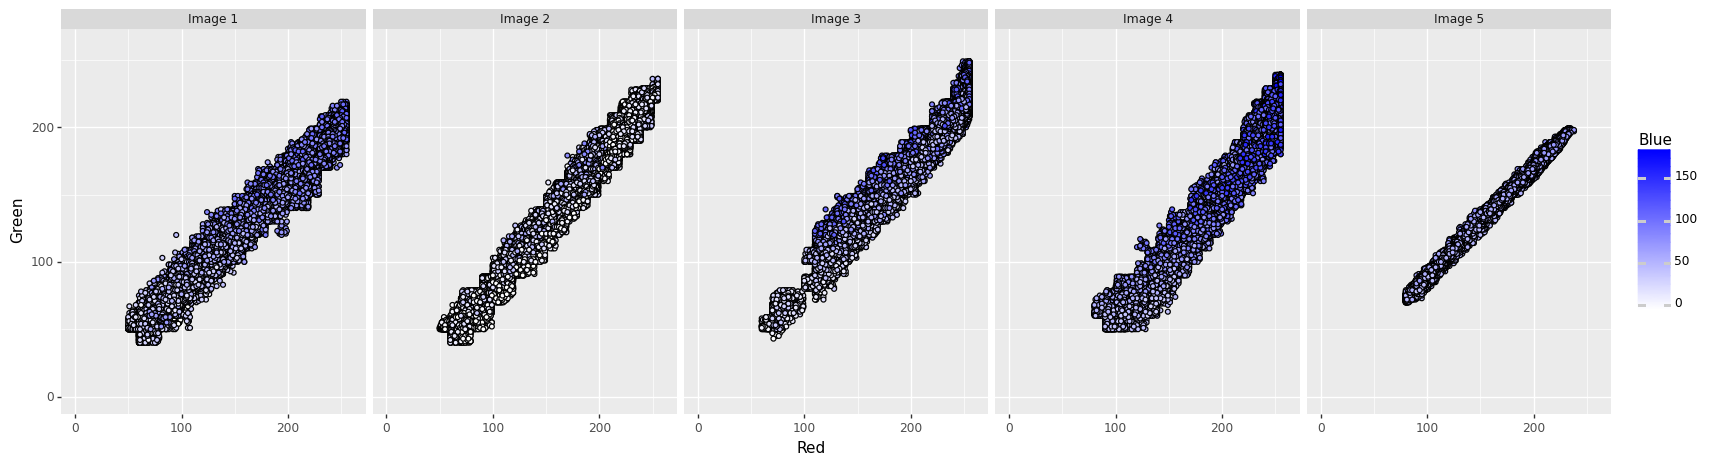

<ggplot: (108652792802)>

In [23]:
(
    p9.ggplot(all_hair_df)+
    p9.geom_point(p9.aes(x="R",y="G",fill="B"))+
    p9.facet_grid(". ~ image_label")+
    p9.scale_fill_gradient(low="#FFFFFF", high="#0000FF")+
    p9.xlim(0,260)+
    p9.ylim(0,260)+
    p9.labs(x="Red",y="Green",fill="Blue")+
    p9.theme(figure_size=(20,5))
)

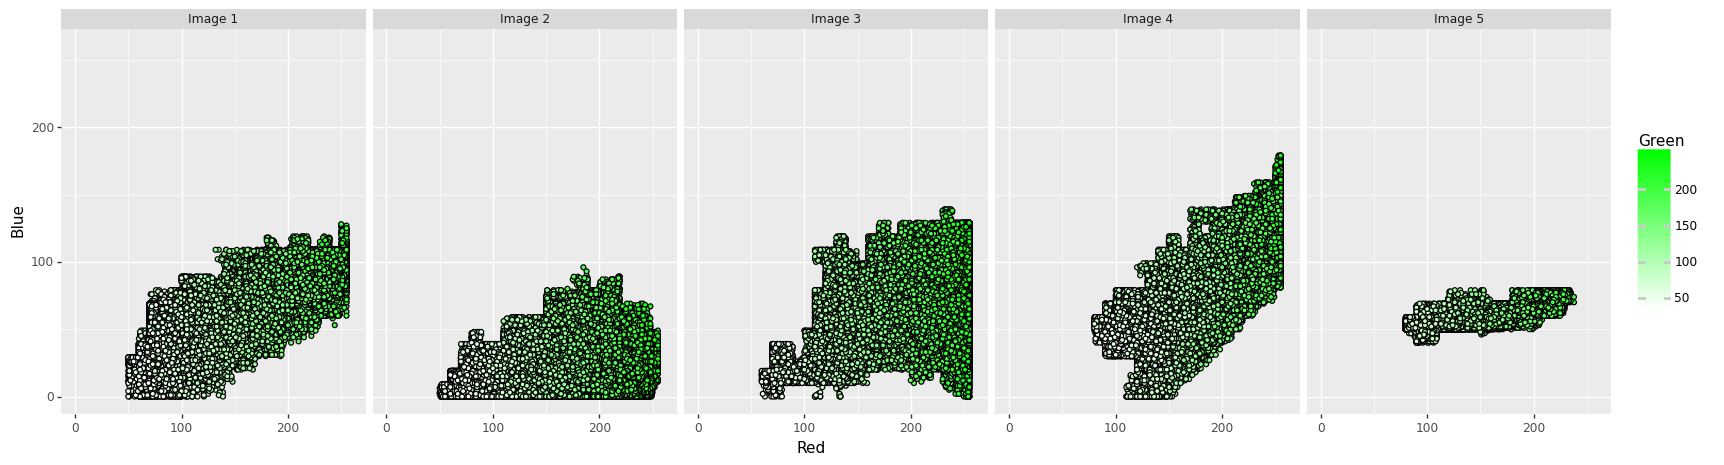

<ggplot: (108677394101)>

In [24]:
(
    p9.ggplot(all_hair_df)+
    p9.geom_point(p9.aes(x="R",fill="G",y="B"))+
    p9.facet_grid(". ~ image_label")+
    p9.scale_fill_gradient(low="#FFFFFF", high="#00FF00")+
    p9.xlim(0,260)+
    p9.ylim(0,260)+
    p9.labs(x="Red",fill="Green",y="Blue")+
    p9.theme(figure_size=(20,5))
)

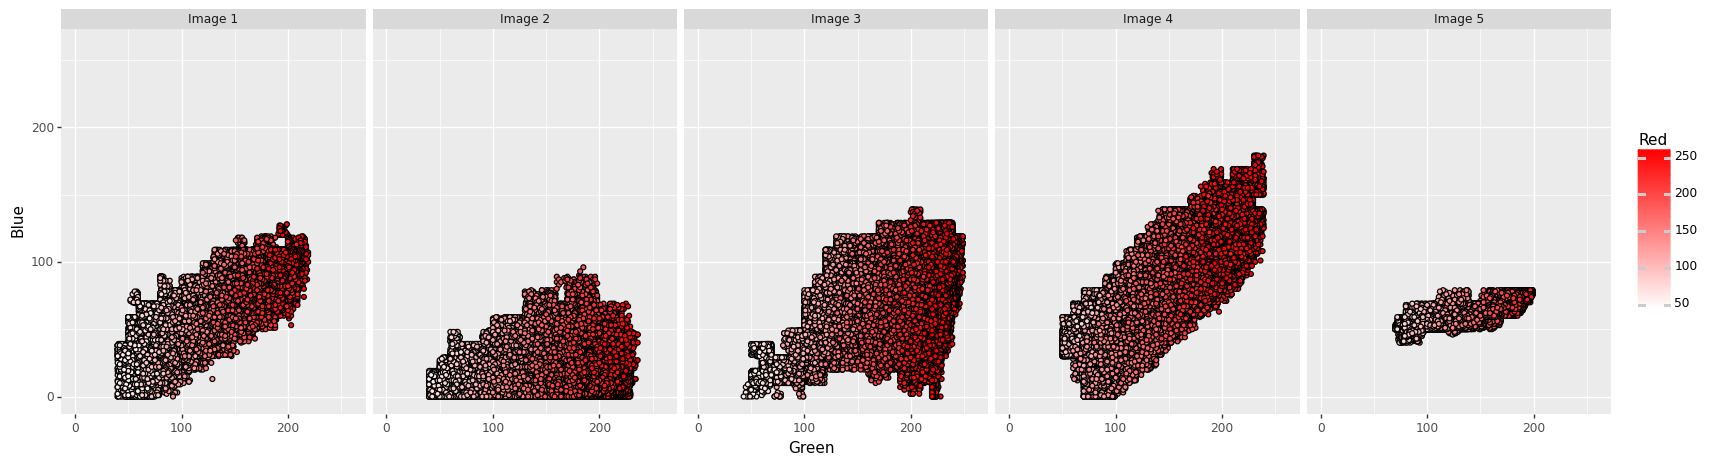

<ggplot: (108711638661)>

In [25]:
(
    p9.ggplot(all_hair_df)+
    p9.geom_point(p9.aes(fill="R",x="G",y="B"))+
    p9.facet_grid(". ~ image_label")+
    p9.scale_fill_gradient(low="#FFFFFF", high="#FF0000")+
    p9.xlim(0,260)+
    p9.ylim(0,260)+
    p9.labs(fill="Red",x="Green",y="Blue")+
    p9.theme(figure_size=(20,5))
)

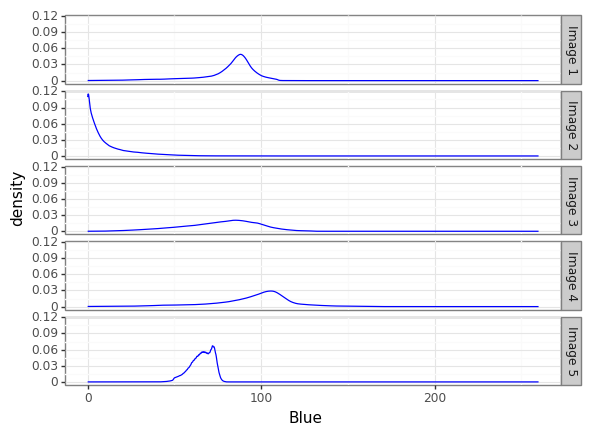

<ggplot: (108625931722)>

In [26]:
(
    p9.ggplot(all_hair_df)+
    p9.geom_density(p9.aes(x="B"),color="blue")+
    p9.facet_grid("image_label~.")+
    p9.theme_bw()+
    p9.xlim(0,260)+
    p9.labs(x="Blue")
)

# Image 3 Skin and Makeup

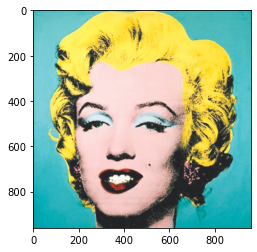

In [27]:
trial3 = extract_print_image(image3_matrix,x_range='full',y_range='full',print_image=True,axis=True)

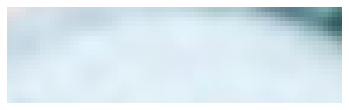

In [28]:
makeup_sample_3 = extract_print_image(image3_matrix,[460,480],[250,320])

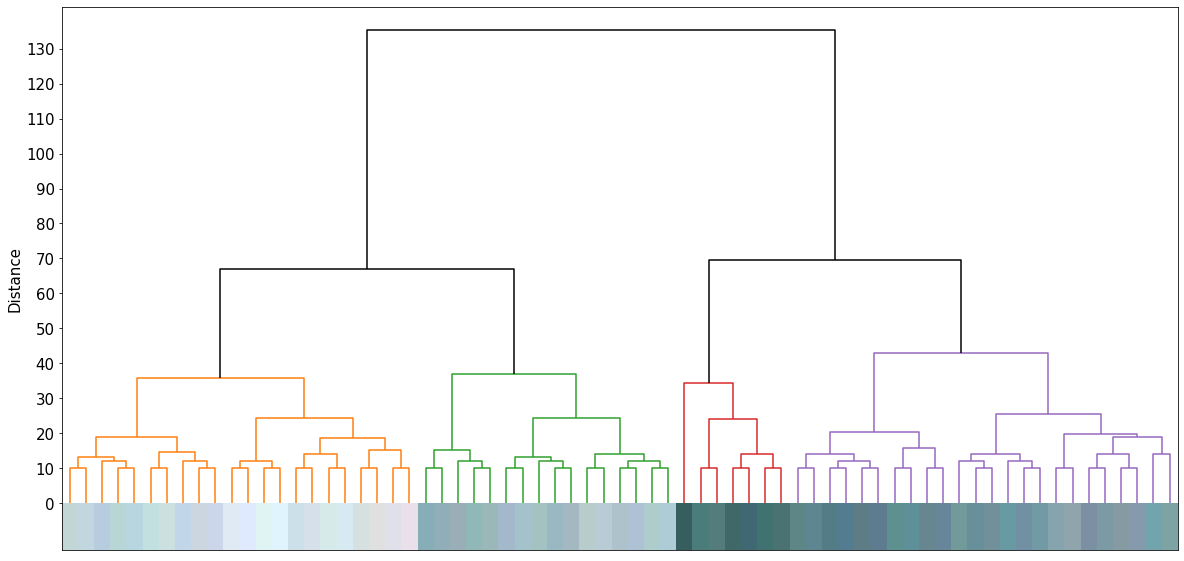

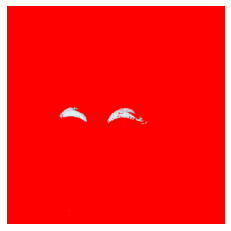

In [29]:
threshold = 50
dg,Z = color_cluster(makeup_sample_3,threshold=threshold)
makeup_df_3 = desired_color_image(image3_matrix,
                                  makeup_sample_3,
                                  dg,
                                  Z,   
                                  threshold,
                                  desired_cluster_order=[0,1],
                                  contrast_color=[255,0,0])

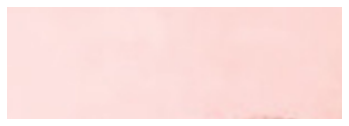

In [30]:
skin_sample_3 = extract_print_image(image3_matrix,[300,400],[300,600])

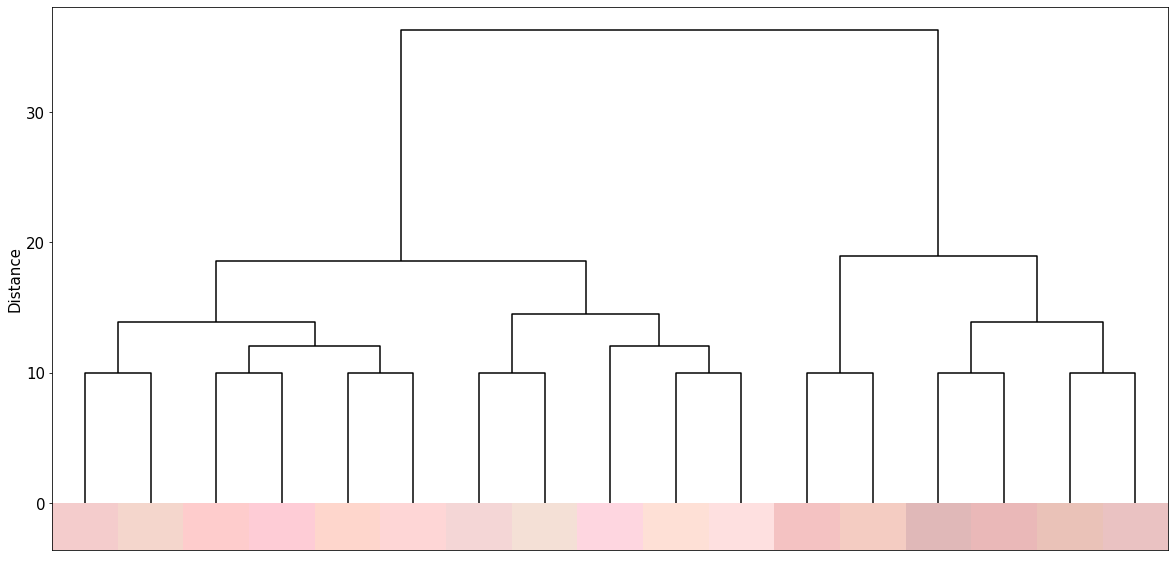

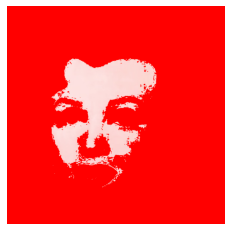

In [31]:
threshold = 0
dg,Z = color_cluster(skin_sample_3,threshold=threshold)
skin_df_3 = desired_color_image(image3_matrix,
                              skin_sample_3,
                              dg,
                              Z,   
                              threshold,
                              desired_cluster_order=[4,5,6,7,8,9,10],
                              contrast_color=[255,0,0])

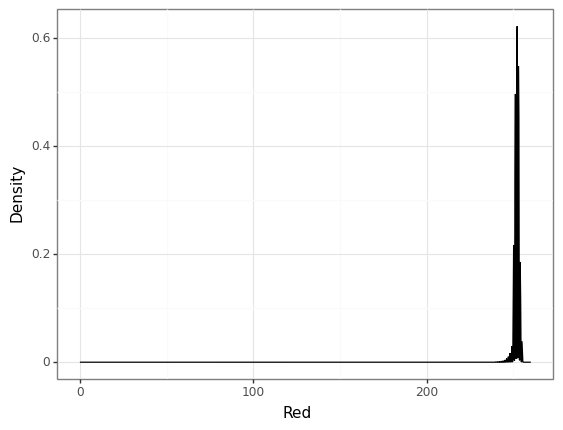

<ggplot: (108588128329)>

In [32]:
(
    p9.ggplot(skin_df_3)+
    p9.geom_density(p9.aes(x="R"))+
    p9.xlim(0,260)+
    p9.labs(x="Red",y="Density")+
    p9.theme(figure_size=(5,5))+
    p9.theme_bw()
)

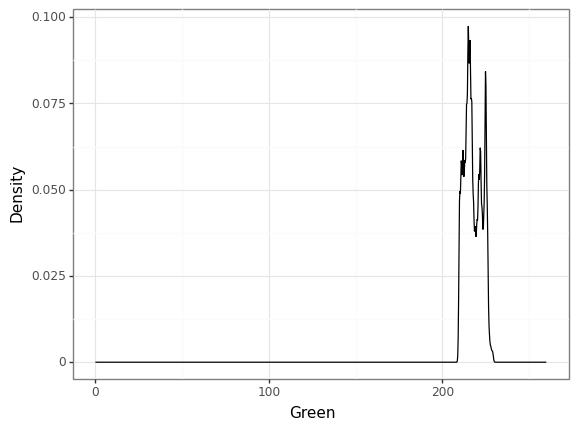

<ggplot: (108588133642)>

In [33]:
(
    p9.ggplot(skin_df_3)+
    p9.geom_density(p9.aes(x="G"))+
    p9.xlim(0,260)+
    p9.labs(x="Green",y="Density")+
    p9.theme(figure_size=(5,5))+
    p9.theme_bw()
)

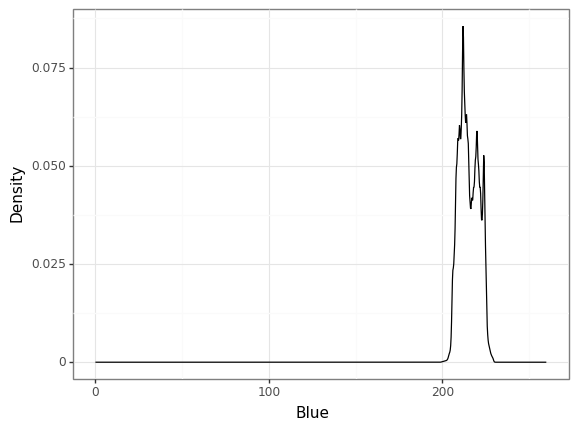

<ggplot: (108668743367)>

In [34]:
(
    p9.ggplot(skin_df_3)+
    p9.geom_density(p9.aes(x="B"))+
    p9.xlim(0,260)+
    p9.labs(x="Blue",y="Density")+
    p9.theme(figure_size=(5,5))+
    p9.theme_bw()
)

In [35]:
makeup_skin_df_3 = pd.concat([makeup_df_3,skin_df_3],axis=0)
makeup_skin_df_3

,R,G,B
0,228,220,224
1,228,221,225
2,232,229,231
3,229,227,229
4,224,223,225
...,...,...,...
117136,253,217,215
117137,252,217,213
117138,251,210,211
117139,252,213,213


In [36]:
makeup_skin_df_3["makeup_or_head"] = ["Makeup"]*makeup_df_3.shape[0]+["Head"]*skin_df_3.shape[0]
makeup_skin_df_3

,R,G,B,makeup_or_head
0,228,220,224,Makeup
1,228,221,225,Makeup
2,232,229,231,Makeup
3,229,227,229,Makeup
4,224,223,225,Makeup
...,...,...,...,...
117136,253,217,215,Head
117137,252,217,213,Head
117138,251,210,211,Head
117139,252,213,213,Head


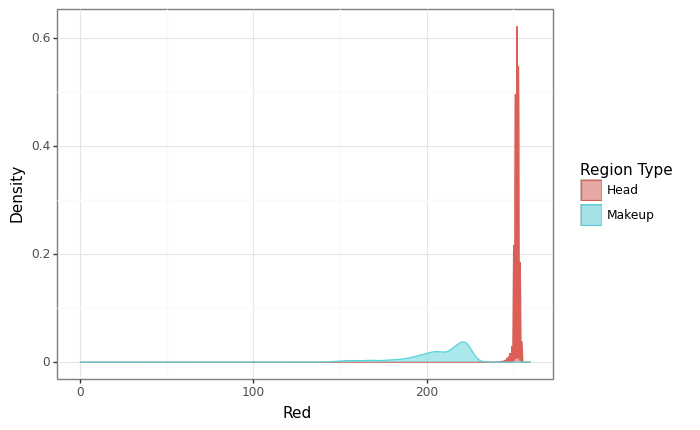

<ggplot: (108675302753)>

In [37]:
(
    p9.ggplot(makeup_skin_df_3)+
    p9.geom_density(p9.aes(x="R",color="makeup_or_head",fill="makeup_or_head"),alpha=0.5)+
    p9.xlim(0,260)+
    p9.labs(x="Red",y="Density",color="Region Type",fill="Region Type")+
    p9.theme(figure_size=(5,5))+
    p9.theme_bw()
)

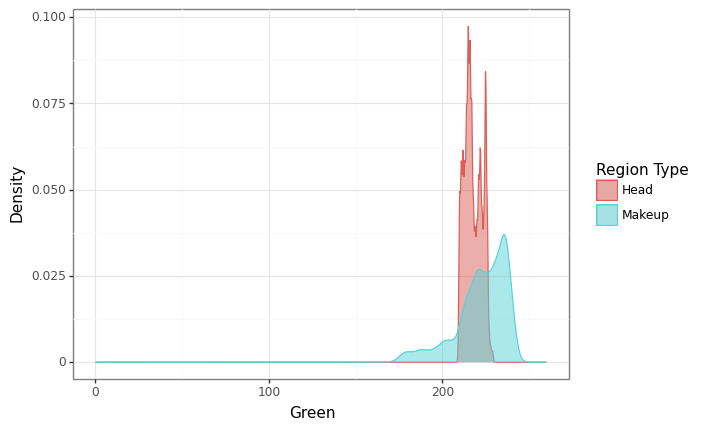

<ggplot: (108713516602)>

In [38]:
(
    p9.ggplot(makeup_skin_df_3)+
    p9.geom_density(p9.aes(x="G",color="makeup_or_head",fill="makeup_or_head"),alpha=0.5)+
    p9.xlim(0,260)+
    p9.labs(x="Green",y="Density",color="Region Type",fill="Region Type")+
    p9.theme(figure_size=(5,5))+
    p9.theme_bw()
)

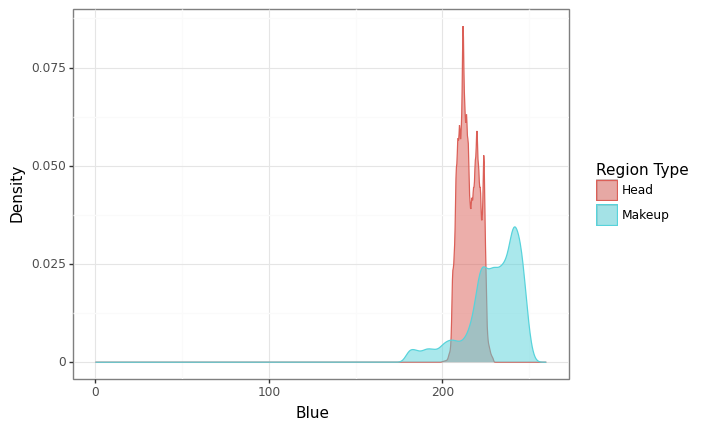

<ggplot: (108711579670)>

In [39]:
(
    p9.ggplot(makeup_skin_df_3)+
    p9.geom_density(p9.aes(x="B",color="makeup_or_head",fill="makeup_or_head"),alpha=0.5)+
    p9.xlim(0,260)+
    p9.labs(x="Blue",y="Density",color="Region Type",fill="Region Type")+
    p9.theme(figure_size=(5,5))+
    p9.theme_bw()
)

# Image 4 Restoration

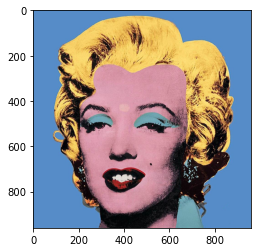

In [40]:
trial4 = extract_print_image(image4_matrix,x_range='full',y_range='full',print_image=True,axis=True)

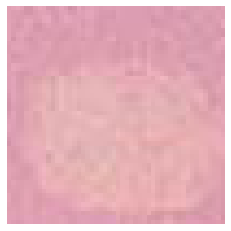

In [41]:
bullet_sample_4 = extract_print_image(image4_matrix,[400,450],[375,425])

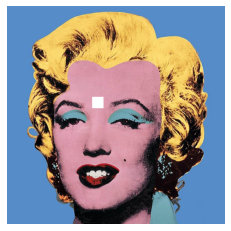

In [42]:
image4_matrix_mod = image4_matrix.copy()
image4_matrix_mod[400:450,375:425,:] = [255,255,255]
skin_without_forehead_4 = extract_print_image(image4_matrix_mod)

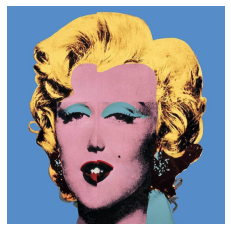

In [43]:
image4_matrix_mod = np.delete(image4_matrix, range(400,450+1), axis=0)
image4_matrix_mod = np.delete(image4_matrix_mod, range(375,425+1), axis=1)
skin_without_forehead_4 = extract_print_image(image4_matrix_mod)

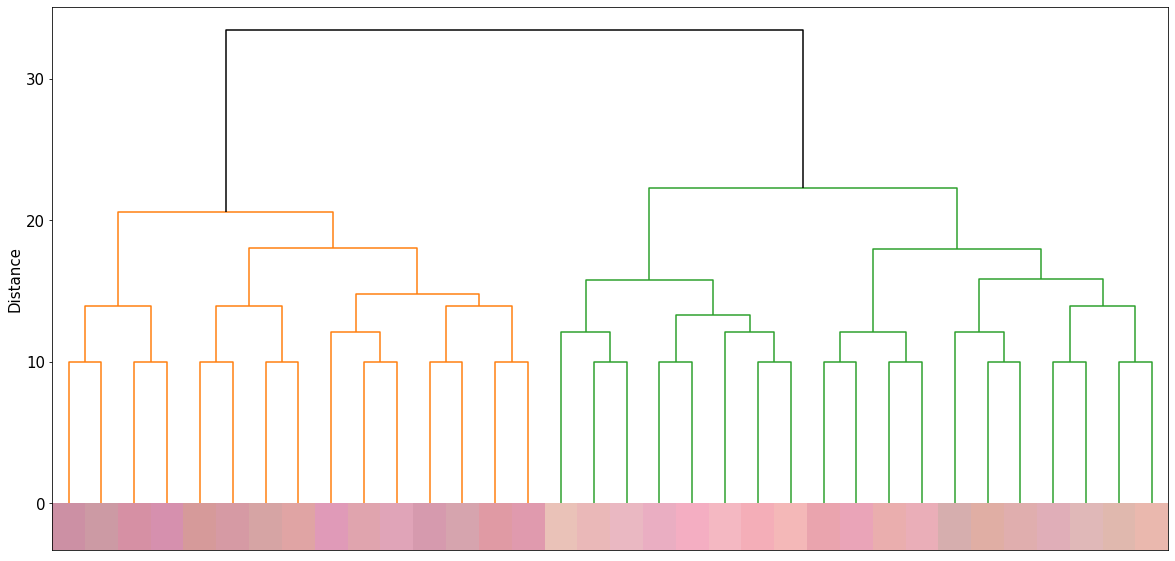

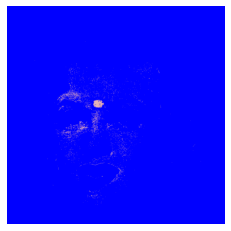

In [44]:
threshold = 30
dg,Z = color_cluster(bullet_sample_4,threshold=threshold)
bullet_df_4 = desired_color_image(image4_matrix,
                                  bullet_sample_4,
                                  dg,
                                  Z,   
                                  threshold,
                                  desired_cluster_order=[1],
                                  contrast_color=[0,0,255])

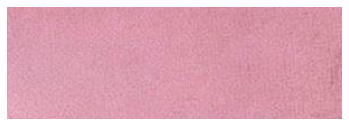

In [45]:
skin_sample_4 = extract_print_image(image4_matrix,[300,400],[300,600])

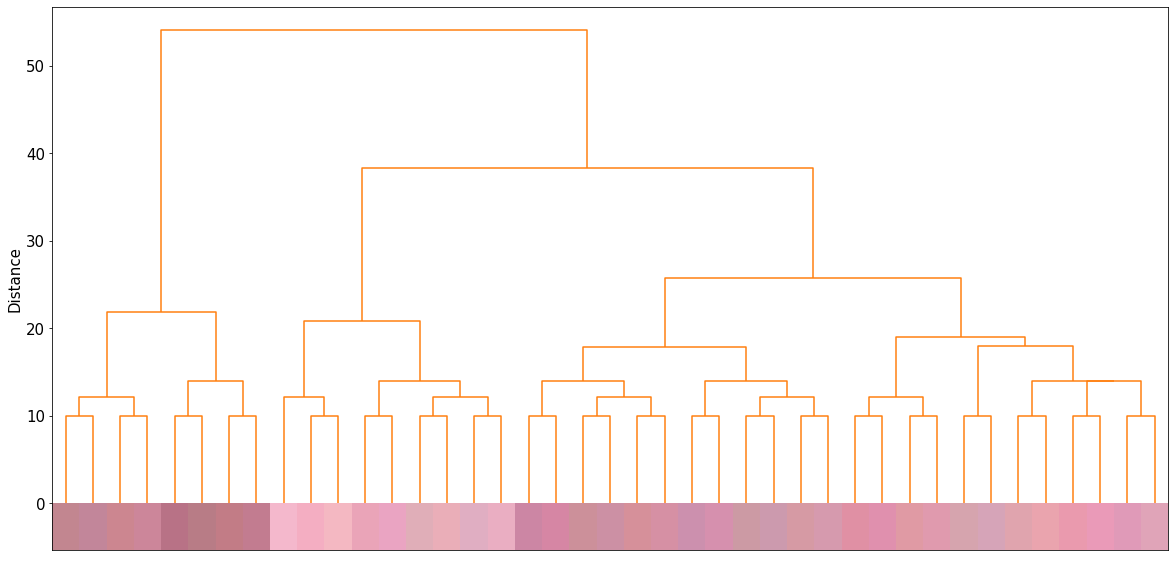

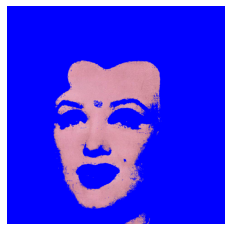

In [46]:
threshold = 60
dg,Z = color_cluster(skin_sample_4,threshold=threshold)
skin_df_4 = desired_color_image(image4_matrix,
                                skin_sample_4,
                                dg,
                                Z,   
                                threshold,
                                desired_cluster_order=[0],
                                contrast_color=[0,0,255])

In [47]:
bullet_skin_df_4 = pd.concat([bullet_df_4,skin_df_4],axis=0)
bullet_skin_df_4

,R,G,B
0,237,188,171
1,210,179,177
2,234,163,171
3,232,161,175
4,233,162,180
...,...,...,...
179859,214,142,164
179860,213,139,162
179861,207,132,155
179862,191,123,144


In [48]:
bullet_skin_df_4["bullet_or_skin"] = ["Bullet"]*bullet_df_4.shape[0]+["Skin"]*skin_df_4.shape[0]
bullet_skin_df_4

,R,G,B,bullet_or_skin
0,237,188,171,Bullet
1,210,179,177,Bullet
2,234,163,171,Bullet
3,232,161,175,Bullet
4,233,162,180,Bullet
...,...,...,...,...
179859,214,142,164,Skin
179860,213,139,162,Skin
179861,207,132,155,Skin
179862,191,123,144,Skin


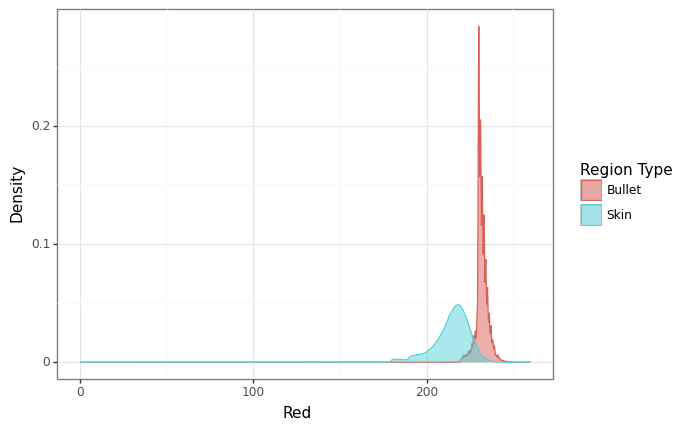

<ggplot: (108701464251)>

In [49]:
(
    p9.ggplot(bullet_skin_df_4)+
    p9.geom_density(p9.aes(x="R",color="bullet_or_skin",fill="bullet_or_skin"),alpha=0.5)+
    p9.xlim(0,260)+
    p9.labs(x="Red",y="Density",color="Region Type",fill="Region Type")+
    p9.theme(figure_size=(5,5))+
    p9.theme_bw()
)

In [50]:
bullet_R_mean_4 = bullet_skin_df_4.loc[bullet_skin_df_4.bullet_or_skin == "Bullet","R"].mean()
skin_R_mean_4 = bullet_skin_df_4.loc[bullet_skin_df_4.bullet_or_skin == "Skin","R"].mean()
bs_R_diff_4 = round(bullet_R_mean_4-skin_R_mean_4)
bs_R_diff_4

17

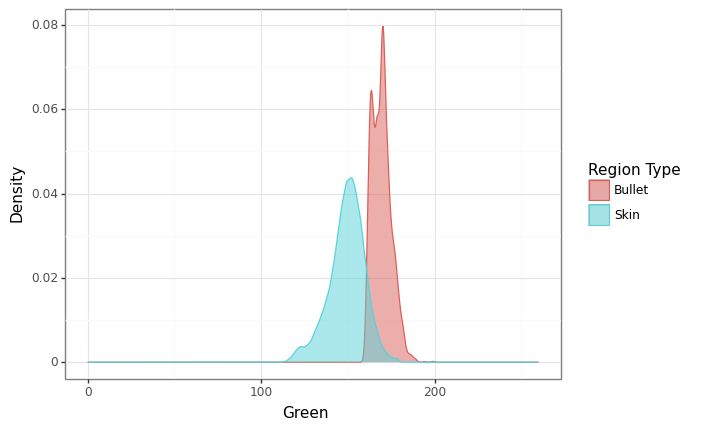

<ggplot: (108652961485)>

In [51]:
(
    p9.ggplot(bullet_skin_df_4)+
    p9.geom_density(p9.aes(x="G",color="bullet_or_skin",fill="bullet_or_skin"),alpha=0.5)+
    p9.xlim(0,260)+
    p9.labs(x="Green",y="Density",color="Region Type",fill="Region Type")+
    p9.theme(figure_size=(5,5))+
    p9.theme_bw()
)

In [52]:
bullet_G_mean_4 = bullet_skin_df_4.loc[bullet_skin_df_4.bullet_or_skin == "Bullet","G"].mean()
skin_G_mean_4 = bullet_skin_df_4.loc[bullet_skin_df_4.bullet_or_skin == "Skin","G"].mean()
bs_G_diff_4 = round(bullet_G_mean_4-skin_G_mean_4)
bs_G_diff_4

20

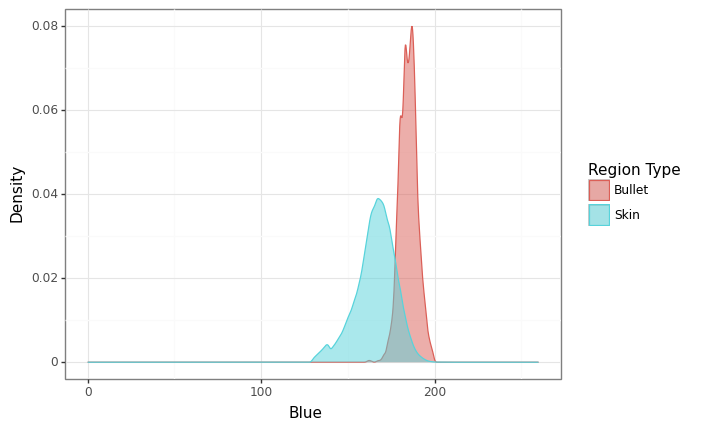

<ggplot: (108674899755)>

In [53]:
(
    p9.ggplot(bullet_skin_df_4)+
    p9.geom_density(p9.aes(x="B",color="bullet_or_skin",fill="bullet_or_skin"),alpha=0.5)+
    p9.xlim(0,260)+
    p9.labs(x="Blue",y="Density",color="Region Type",fill="Region Type")+
    p9.theme(figure_size=(5,5))+
    p9.theme_bw()
)

In [54]:
bullet_B_mean_4 = bullet_skin_df_4.loc[bullet_skin_df_4.bullet_or_skin == "Bullet","B"].mean()
skin_B_mean_4 = bullet_skin_df_4.loc[bullet_skin_df_4.bullet_or_skin == "Skin","B"].mean()
bs_B_diff_4 = round(bullet_B_mean_4-skin_B_mean_4)
bs_B_diff_4

19

In [55]:
bullet_unique_list_4 = [list(i) for i in np.unique(bullet_df_4,axis=0)]

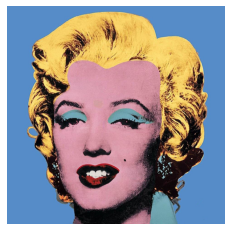

In [56]:
image4_matrix_mod = image4_matrix.copy()
for row in range(400,450+1):
    for col in range(375,425+1):
        if list(image4_matrix_mod[row,col,:]) in bullet_unique_list_4:
            image4_matrix_mod[row,col,0] = image4_matrix_mod[row,col,0] - bs_R_diff_4
            image4_matrix_mod[row,col,1] = image4_matrix_mod[row,col,1] - bs_G_diff_4
            image4_matrix_mod[row,col,2] = image4_matrix_mod[row,col,2] - bs_B_diff_4
image4_matrix_mod = extract_print_image(image4_matrix_mod)

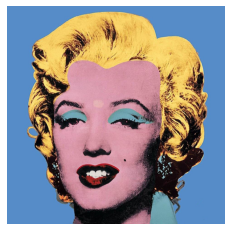

In [57]:
trial = extract_print_image(image4_matrix)